# An inquest into SBERT embedding capabilities

Here, approaches to horizontal bond extraction based on section embeddings are examined using the SBERT model as provided by hugging-face transformers  

In [ ]:
!pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

## Clustering embeddings

Admittedly, the criteria for connecting sections in the current approach are defined fairly loosely. This leads to fuzzy evaluation results and is in general problematic.

An alternative would be to solve a clustering problem in the embedding space. The sections in well-defined clusters will then be densely connected. This approach allows for meaningful evaluation with clustering metrics, such as silhouette.

In [72]:
# Extract list of all sections from pickled file
import pickle

with open('doc_texts.txt', 'rb') as dumpfile:
  texts = pickle.load(dumpfile)

# Many empty strings - parsing artifact
texts = list(filter(lambda x: x != '', texts))
texts = [txt.lower() for txt in texts]

In [27]:
#Tokenize sentences
encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=24, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
text_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

NameError: name 'tokenizer' is not defined

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
!pip install scikit-plot
from scikitplot.metrics import plot_silhouette

100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


Optimal hyperpar: 0.4 17
Silhouette score: 0.25824693


<Axes: title={'center': 'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

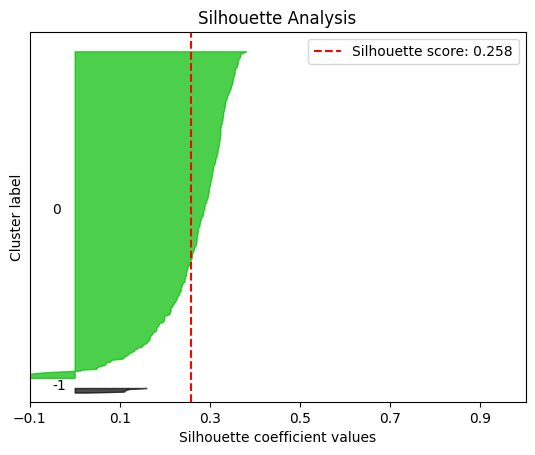

In [ ]:
best_model = None
max_score = -1.5
hp_opt = []

for eps in tqdm(np.linspace(0.01, 0.4, 100)):
  for min_samples in range(2, 30):
    clust = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    clust.fit(np.array(text_embeddings))

    if np.unique(clust.labels_).shape[0] > 1:
      if silhouette_score(text_embeddings, clust.labels_) > max_score:
        max_score = silhouette_score(text_embeddings, clust.labels_)
        best_model = clone(clust)
        hp_opt = [eps, min_samples]
best_model.fit(np.array(text_embeddings))

# Assert that we got more than one cluster
assert(np.unique(clust.labels_).shape[0] > 1)

print('\nOptimal hyperpar:', *hp_opt)
print('Silhouette score:', silhouette_score(text_embeddings, clust.labels_))

plot_silhouette(text_embeddings, clust.labels_)

## KMeans clustering

Fails utterly. Silhouette lower than 0.1 for `n_clusters` up to 40 (with tolerance 1e-2 to 1e-4)

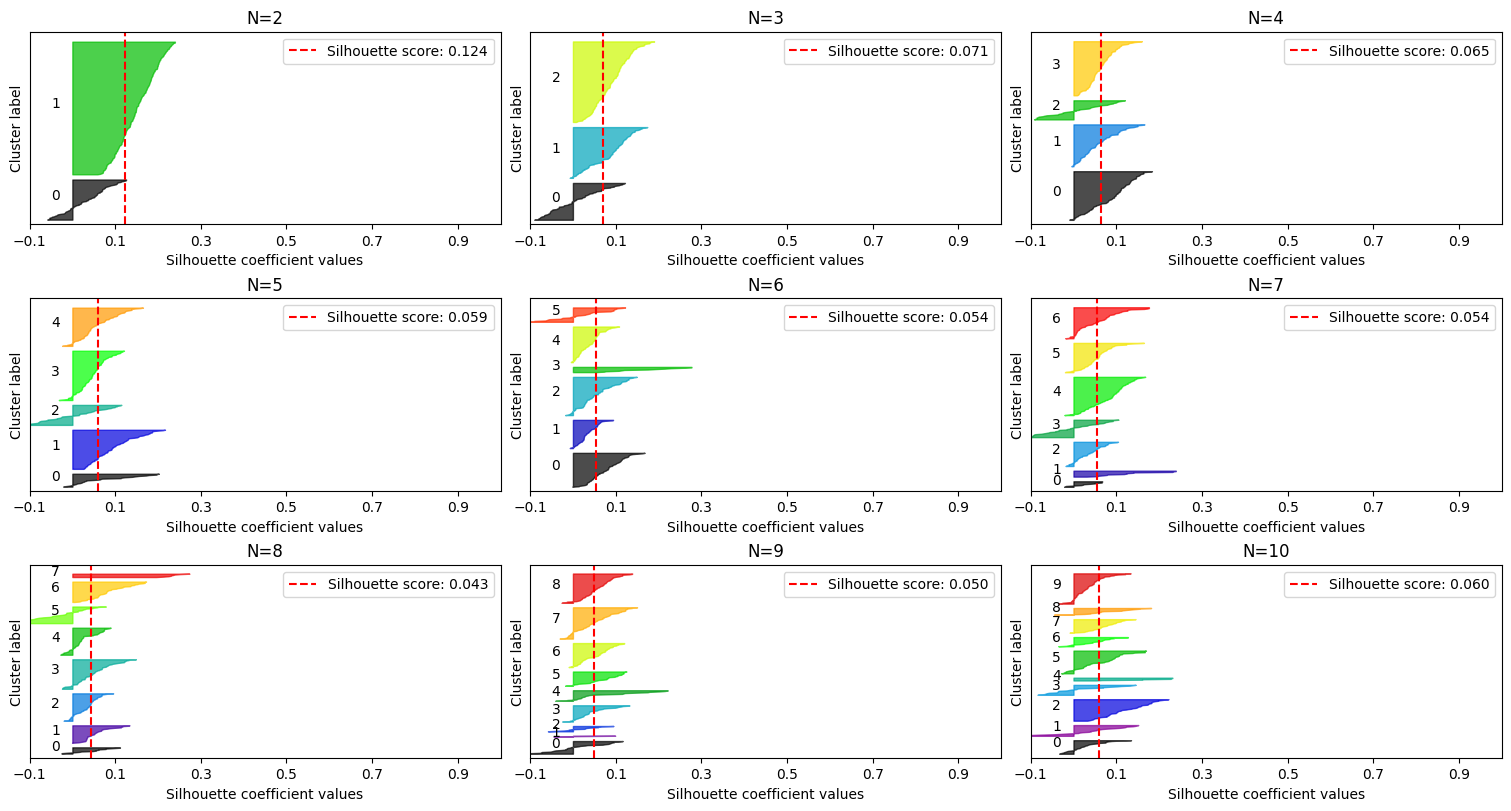

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 8), layout='constrained')

for n_clust in range(2, 11):
  curr_ax = axs[(n_clust - 2) // 3, (n_clust - 2) % 3]

  clust = KMeans(n_clusters=n_clust, tol=1e-4, max_iter=100000)
  clust.fit(text_embeddings)
  if np.unique(clust.labels_).shape[0] >= 2:
    plot_silhouette(text_embeddings, clust.labels_, ax=curr_ax)
  else:
    plt.text(0.5, 0.5, "NoConv")
  curr_ax.set_title(f'N={n_clust}')

## Keyword extraction

Here, sections are connected when they share a key named entity among the top K (few tens) n-grams.

In [ ]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
from keybert import KeyBERT

In [ ]:
from transformers.pipelines import pipeline

hf_model = pipeline("feature-extraction", model="ai-forever/sbert_large_nlu_ru")
kw_model = KeyBERT(model=hf_model)

In [ ]:
kw_model.extract_keywords('''Я вот что скажу: вообще не
понятно, как можно не любить стволы родных берез? Человек, родившийся и
выросший в России, не любит своей природы? Не понимает ее красоты? Ее заливных
лугов? Утреннего леса? Бескрайних полей? Ночных трелей соловья? Осеннего листопада?
Первой пороши? Июльского сенокоса? Степных просторов? Русской песни? Русского
характера? Ведь ты же русский? Ты родился в России? Ты ходил в среднюю школу?
Ты служил в армии? Ты учился в техникуме? Ты работал на заводе? Ты ездил в
Бобруйск? Ездил в Бобруйск? В Бобруйск ездил? Ездил, а? Ты в Бобруйск ездил, а?''',
                          keyphrase_ngram_range=(1, 3),
                          top_n=15)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[('ты родился россии', 0.4372),
 ('родился россии ты', 0.42),
 ('стволы родных берез', 0.4193),
 ('родных берез', 0.4149),
 ('русский ты родился', 0.4138),
 ('ездил ты бобруйск', 0.4116),
 ('ты ездил бобруйск', 0.4045),
 ('ты бобруйск ездил', 0.4005),
 ('просторов русской песни', 0.3943),
 ('природы не понимает', 0.3924),
 ('любит своей природы', 0.3886),
 ('степных просторов русской', 0.3817),
 ('любить стволы родных', 0.3772),
 ('просторов русской', 0.3725),
 ('леса бескрайних полей', 0.3697)]